In [26]:
# For the attribute find functions.
import os

from stylex_train import StylEx, Dataset, DistributedSampler, MNIST_1vA

# For setting data src.
from  stylex_train import image_noise, styles_def_to_tensor, make_weights_for_balanced_classes, cycle, default

from mobilenet_classifier import MobileNet
import torch
from torch.utils import data
import math
import tqdm

import multiprocessing
from torchvision.utils import make_grid
from PIL import Image

# For reading lines and converting them to dict.
import ast

import h5py

NUM_CORES = multiprocessing.cpu_count()

def plot_image(tensor) -> None:
    """
    Plots an image from a tensor.
    """
    grid = make_grid(tensor,nrow=5)
    # Add 0.5 after unnormalizing to [0, 255] to round to nearest integer
    ndarr = grid.mul(255).add_(0.5).clamp_(0, 255).permute(1, 2, 0).to('cpu', torch.uint8).numpy()
    im = Image.fromarray(ndarr)

    # Plot PIL image using plt.imshow
    display(im)


def set_data_src(folder='./', dataset_name=None, image_size=32, batch_size=16, num_workers=4,
                 is_ddp=False, rank=0, world_size=1):
    if dataset_name is None:
        dataset = Dataset(folder, image_size)
        num_workers = default(num_workers, NUM_CORES if not is_ddp else 0)

        sampler = DistributedSampler(dataset, rank=rank, num_replicas=world_size,
                                     shuffle=True) if is_ddp else None

        dataloader = data.DataLoader(dataset, num_workers=num_workers,
                                     batch_size=math.ceil(batch_size / world_size), sampler=sampler,
                                     shuffle=False, drop_last=True, pin_memory=True)

    elif dataset_name == 'MNIST':

        dataset = MNIST_1vA(digit=8)

        # weights = make_weights_for_balanced_classes(dataset.dataset, num_classes)
        # sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights))

        dataloader = data.DataLoader(dataset, batch_size=batch_size)
    else:
        raise NotImplementedError("This dataset is not supported yet. Please use dataset_name = None.")

    loader = cycle(dataloader)

    return dataset, loader


def sindex_to_block_idx_and_index(generator, sindex):
    tmp_idx = sindex

    block_idx = None
    idx = None

    for idx, block in enumerate(generator.blocks):
        if tmp_idx < block.num_style_coords:
            block_idx = idx
            idx = tmp_idx
            break
        else:
            tmp_idx = tmp_idx - block.num_style_coords

    return block_idx, idx


def _float_features(values):
    """Returns a float_list from a float / double."""
    return tf.train.Feature(float_list=tf.train.FloatList(value=values))


def get_min_max_style_vectors(stylex, classifier, loader, batch_size, num_images=264, cuda_rank=0, image_size=32):
    minimums = None
    maximums = None

    minimums = None
    maximums = None

    for _ in range(num_images // batch_size):
        encoder_batch = next(loader).cuda(cuda_rank)

        encoder_output = stylex.encoder(encoder_batch)[0]

        real_classified_logits = classifier.classify_images(encoder_batch)

        noise = image_noise(batch_size, image_size, device=cuda_rank)
        #zero_noise = torch.zeros(batch_size, image_size, image_size, 1).cuda(cuda_rank)


        latent_w = [(torch.cat((encoder_output, real_classified_logits), dim=1),
                     stylex.G.num_layers)]  # Has to be bracketed because expects a noise mix

        # dlatents.append(encoder_output)
        w_latent_tensor = styles_def_to_tensor(latent_w)

        rgb, style_coords = stylex.G(w_latent_tensor, noise, get_style_coords=True)

        if minimums is None or maximums is None:
            minimums = style_coords
            maximums = style_coords
        else:
            minimums = torch.minimum(minimums, style_coords)
            maximums = torch.maximum(maximums, style_coords)

    minimums = torch.min(minimums, dim=0)[0]
    maximums = torch.max(maximums, dim=0)[0]

    return minimums, maximums


def filter_unstable_images(style_change_effect: torch.Tensor,
                           effect_threshold: float = 0.3,
                           num_indices_threshold: int = 150) -> torch.Tensor:
    """Filters out images which are affected by too many S values."""
    unstable_images = (
                torch.sum(torch.abs(style_change_effect) > effect_threshold, dim=(1, 2, 3)) > num_indices_threshold)
    style_change_effect[unstable_images] = 0
    return style_change_effect


def run_attrfind(
        data='/home/tannin/Desktop/tmp/Explaining-In-Style-Reproducibility-Study/plant-village/all/',
        stylex_path='/home/tannin/Desktop/tmp/Explaining-In-Style-Reproducibility-Study/stylex/models/plants_64_golden/model_260.pt',
        classifier_name='/home/tannin/Desktop/tmp/Explaining-In-Style-Reproducibility-Study/stylex/trained_classifiers/plant-village-64_2.pt',
        image_size=64,
        num_images=4,
        batch_size=16,
        dataset_name=None,
        s_shift_size=0.5,
        att_find_text_file="./att_find/att_find_computations.txt"
):
    with torch.no_grad():
        dataset, loader = set_data_src(data, dataset_name, image_size, batch_size)
        # Since attribute find is not helped by having multiple GPU's, we hardcode cuda_rank to 0.
        cuda_rank = 0

        stylex = StylEx(image_size=image_size)

        # smt like this

        stylex.load_state_dict(torch.load(stylex_path)["StylEx"])

        classifier = MobileNet(classifier_name, cuda_rank=cuda_rank, output_size=2, image_size=image_size)

        minimums, maximums = get_min_max_style_vectors(stylex, classifier, loader, batch_size=batch_size,
                                                       cuda_rank=cuda_rank, image_size=image_size)

        # Dictionary of features
        style_vector_amount = len(minimums)

        # Check if the att_find_text_file path exists, otherwise create a directory with the text file in there
        if not os.path.exists(os.path.dirname(att_find_text_file)):
            os.makedirs(os.path.dirname(att_find_text_file))

        noise = image_noise(batch_size, image_size, device=cuda_rank)[0].unsqueeze(0)

        #zero_noise = torch.zeros(1, image_size, image_size, 1).cuda(cuda_rank)

        # Check if the att_find_text_file exists, otherwise do the attfind computations.


        batch = next(loader).cuda(cuda_rank)
        batch = next(loader).cuda(cuda_rank)

        for i in range(10,20):

            img = batch[i].unsqueeze(0)
            img_logits = classifier.classify_images(img)

            plot_image(img)

            w = stylex.encoder(img)[0].unsqueeze(0)
            latent_w = [(torch.cat((w, img_logits), dim=1), stylex.G.num_layers)]  
            w_latent_tensor = styles_def_to_tensor(latent_w)

            img_generated, style_coords = stylex.G(w_latent_tensor, noise, get_style_coords=True)
            img_generated_logits = classifier.classify_images(img_generated)

            plot_image(img_generated)

            print(f'Logits of original image: {img_logits}')
            print(f'Logits of generated image: {img_generated_logits}')

            style_change_effect = torch.Tensor(1, style_coords.shape[1], 2, 2)

            largest_diff = -1e10
            largest_diff_idx = None
            largest_diff_direction = None

            for sindex in range(style_coords.shape[1]):
                block_idx, weight_idx = sindex_to_block_idx_and_index(stylex.G, sindex)

                block = stylex.G.blocks[block_idx]

                # block.style1.bias [block.input_channels]
                # block.style2.bias [block.filters]

                current_style_layer = None
                one_hot = None

                if weight_idx < block.input_channels:
                    # While we're in style 1.
                    current_style_layer = block.to_style1
                    one_hot = torch.zeros((1, block.input_channels)).cuda(cuda_rank)
                else:
                    weight_idx -= block.input_channels
                    current_style_layer = block.to_style2
                    one_hot = torch.zeros((1, block.filters)).cuda(cuda_rank)

                one_hot[:, weight_idx] = 1

                s_shift_down = one_hot * (
                            (minimums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                s_shift_up = one_hot * ((maximums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(
                    1)

                for direction_index, shift in enumerate([s_shift_down, s_shift_up]):
                    # for image_index, individual_shift in enumerate(shift):

                    image_index = 0

                    shift = shift.squeeze(0)

                    if (shift==0).all():
                        print('OMG NO SHIFT')

                    current_style_layer.bias += shift
                    perturbed_generated_images, style_coords = stylex.G(
                        w_latent_tensor,
                        noise,
                        get_style_coords=True)
                    shift_classification = classifier.classify_images(perturbed_generated_images)
                    style_change_effect[image_index, sindex, direction_index] = shift_classification - img_generated_logits

                    if largest_diff < style_change_effect[image_index, sindex, direction_index,  1]:
                        largest_diff = style_change_effect[image_index, sindex, direction_index, 1]
                        largest_diff_idx = (image_index, sindex, direction_index)
                        largest_diff_direction = direction_index

                    
                    if sindex == 32 and direction_index == 0:
                        plot_image(perturbed_generated_images)                
                    current_style_layer.bias -= shift

            print(f'Largest diff: {largest_diff}')
            print(f'Largest diff idx: {largest_diff_idx}')
            print(f'Largest diff direction: {largest_diff_direction}')


            for _cls in [0, 1]:

                changes_not8 = style_change_effect[0, :, :, _cls] # change 1 to 0 depending on which class we want to inspect
                changes_not8_flat = changes_not8.view(-1)
                changes_not8_sorted, changes_not8_indices = torch.sort(changes_not8_flat, descending=True)

                k_max = 20
                one_hot = None


                # Change the biases in the direction specified.
                
                images = []
                
                for k in range(1, k_max + 1):

                    top_k_changes, top_k_sindex, top_k_directions = changes_not8_sorted[:k], changes_not8_indices[:k] / 2, changes_not8_indices[:k] % 2

                    

                    for i in range(k):

                        sindex = int(top_k_sindex[i])

                        block_idx, weight_idx = sindex_to_block_idx_and_index(stylex.G, sindex)

                        block = stylex.G.blocks[block_idx]
                        if weight_idx < block.input_channels:
                            # While we're in style 1.
                            current_style_layer = block.to_style1
                            one_hot = torch.zeros((1, block.input_channels)).cuda(cuda_rank)
                        else:
                            weight_idx -= block.input_channels
                            current_style_layer = block.to_style2
                            one_hot = torch.zeros((1, block.filters)).cuda(cuda_rank)

                        
                        one_hot[:, weight_idx] = 1

                        if top_k_directions[i] == 0:
                            individual_shift = one_hot * (
                                        (minimums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                        else:
                            individual_shift = one_hot * (
                                        (maximums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                        


                        current_style_layer.bias += individual_shift[0]

            
                    # Generate the perturbed image
                    perturbed_img_generated = stylex.G(w_latent_tensor,
                                                                                        noise
                                                                        )            

                    images.append(perturbed_img_generated)

                    # Get the logits of the perturbed image

                    perturbed_img_generated_logits = classifier.classify_images(perturbed_img_generated)

                    print(f'Logits of image with top-{k} attributes flipped: {perturbed_img_generated_logits}')


                    for i in range(k):

                        sindex = int(top_k_sindex[i])

                        block_idx, weight_idx = sindex_to_block_idx_and_index(stylex.G, sindex)

                        block = stylex.G.blocks[block_idx]
                        if weight_idx < block.input_channels:
                            # While we're in style 1.
                            current_style_layer = block.to_style1
                            one_hot = torch.zeros((1, block.input_channels)).cuda(cuda_rank)
                        else:
                            weight_idx -= block.input_channels
                            current_style_layer = block.to_style2
                            one_hot = torch.zeros((1, block.filters)).cuda(cuda_rank)
                        
                        one_hot[:, weight_idx] = 1

                        if top_k_directions[i] == 0:
                            individual_shift = one_hot * (
                                        (minimums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                        else:
                            individual_shift = one_hot * (
                                        (maximums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)


                        current_style_layer.bias -= individual_shift[0]


                # stack list of tensor images into a single tensor

                images = torch.cat(images, dim=0)


                plot_image(images)

                import random

                images = []

                k = 10
                top_k_changes, top_k_sindex, top_k_directions = changes_not8_sorted[:k], changes_not8_indices[:k] / 2, changes_not8_indices[:k] % 2
                
                for j in range(10):

                    indices = random.choices(range(10), k=3)

                    for i in indices:
                        sindex = int(top_k_sindex[i])

                        block_idx, weight_idx = sindex_to_block_idx_and_index(stylex.G, sindex)

                        block = stylex.G.blocks[block_idx]
                        if weight_idx < block.input_channels:
                            # While we're in style 1.
                            current_style_layer = block.to_style1
                            one_hot = torch.zeros((1, block.input_channels)).cuda(cuda_rank)
                        else:
                            weight_idx -= block.input_channels
                            current_style_layer = block.to_style2
                            one_hot = torch.zeros((1, block.filters)).cuda(cuda_rank)

                        
                        one_hot[:, weight_idx] = 1

                        if top_k_directions[i] == 0:
                            individual_shift = one_hot * (
                                        (minimums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                        else:
                            individual_shift = one_hot * (
                                        (maximums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                        




                        current_style_layer.bias += individual_shift[0]


                    # Generate the perturbed image
                    perturbed_img_generated = stylex.G(w_latent_tensor,
                                                                            noise,
                                                                    )            

                    images.append(perturbed_img_generated)

                    # Get the logits of the perturbed image

                    perturbed_img_generated_logits = classifier.classify_images(perturbed_img_generated)

                    print(f'Logits of image with top-{indices} attributes flipped: {perturbed_img_generated_logits}')

                    for i in indices:

                        sindex = int(top_k_sindex[i])

                        block_idx, weight_idx = sindex_to_block_idx_and_index(stylex.G, sindex)

                        block = stylex.G.blocks[block_idx]
                        if weight_idx < block.input_channels:
                            # While we're in style 1.
                            current_style_layer = block.to_style1
                            one_hot = torch.zeros((1, block.input_channels)).cuda(cuda_rank)
                        else:
                            weight_idx -= block.input_channels
                            current_style_layer = block.to_style2
                            one_hot = torch.zeros((1, block.filters)).cuda(cuda_rank)

                        
                        one_hot[:, weight_idx] = 1

                        if top_k_directions[i] == 0:
                            individual_shift = one_hot * (
                                        (minimums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)
                        else:
                            individual_shift = one_hot * (
                                        (maximums[sindex] - style_coords[:, sindex]) * s_shift_size).unsqueeze(1)





                        current_style_layer.bias -= individual_shift[0]


                images = torch.cat(images, dim=0)

                print(images.shape)

                plot_image(images)

Using cache found in /home/tannin/.cache/torch/hub/pytorch_vision_v0.10.0


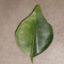

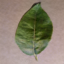

Logits of original image: tensor([[-5.1231,  4.6625]], device='cuda:0')
Logits of generated image: tensor([[-6.6379,  5.9388]], device='cuda:0')


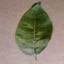

Largest diff: 2.117603302001953
Largest diff idx: (0, 2436, 1)
Largest diff direction: 1
Logits of image with top-1 attributes flipped: tensor([[-2.2262,  2.0522]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[-0.1739,  0.1955]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[ 0.7530, -0.5280]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[ 1.5120, -1.0956]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[ 1.6960, -1.5819]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[ 1.9224, -1.8307]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[ 1.9231, -1.7659]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[ 2.7250, -2.6729]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[ 2.8116, -2.4627]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[ 2.2600, -1.8478]

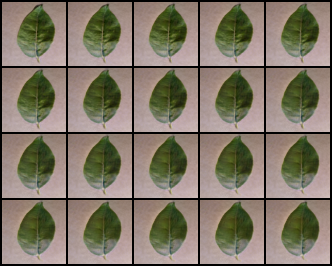

Logits of image with top-[0, 4, 2] attributes flipped: tensor([[ 0.8333, -0.5543]], device='cuda:0')
Logits of image with top-[6, 7, 4] attributes flipped: tensor([[-1.5201,  1.5713]], device='cuda:0')
Logits of image with top-[4, 7, 2] attributes flipped: tensor([[-0.7250,  0.8956]], device='cuda:0')
Logits of image with top-[8, 3, 1] attributes flipped: tensor([[-1.5662,  1.5362]], device='cuda:0')
Logits of image with top-[4, 3, 7] attributes flipped: tensor([[-0.7573,  0.6823]], device='cuda:0')
Logits of image with top-[9, 2, 4] attributes flipped: tensor([[-2.0233,  1.8971]], device='cuda:0')
Logits of image with top-[9, 2, 0] attributes flipped: tensor([[-0.4889,  0.5720]], device='cuda:0')
Logits of image with top-[9, 9, 8] attributes flipped: tensor([[-2.2893,  1.8981]], device='cuda:0')
Logits of image with top-[5, 2, 3] attributes flipped: tensor([[-0.2643,  0.4312]], device='cuda:0')
Logits of image with top-[9, 4, 0] attributes flipped: tensor([[-0.6642,  0.6185]], device=

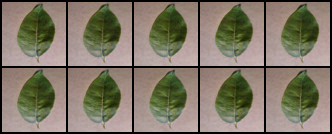

Logits of image with top-1 attributes flipped: tensor([[-9.0320,  8.0564]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[-10.0113,   8.9963]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[-10.1252,   9.2578]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[-10.8887,   9.7848]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[-11.6804,  10.5538]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[-11.5948,  10.4654]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[-11.7026,  10.3136]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[-11.1720,  10.0729]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[-10.8841,   9.9895]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[-11.1556,  10.2380]], device='cuda:0')
Logits of image with top-11 attributes flipped: ten

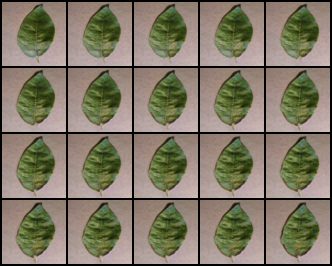

Logits of image with top-[2, 2, 4] attributes flipped: tensor([[-8.5157,  7.4998]], device='cuda:0')
Logits of image with top-[8, 6, 4] attributes flipped: tensor([[-8.5248,  7.7748]], device='cuda:0')
Logits of image with top-[0, 9, 8] attributes flipped: tensor([[-9.5221,  8.5915]], device='cuda:0')
Logits of image with top-[0, 2, 2] attributes flipped: tensor([[-9.6042,  8.6154]], device='cuda:0')
Logits of image with top-[9, 9, 0] attributes flipped: tensor([[-9.4778,  8.4561]], device='cuda:0')
Logits of image with top-[5, 9, 2] attributes flipped: tensor([[-9.0050,  8.0791]], device='cuda:0')
Logits of image with top-[6, 4, 7] attributes flipped: tensor([[-9.6825,  8.9132]], device='cuda:0')
Logits of image with top-[9, 7, 8] attributes flipped: tensor([[-8.9549,  8.0252]], device='cuda:0')
Logits of image with top-[3, 0, 3] attributes flipped: tensor([[-9.8782,  9.0132]], device='cuda:0')
Logits of image with top-[0, 0, 4] attributes flipped: tensor([[-10.2269,   9.1937]], devic

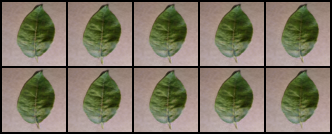

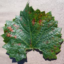

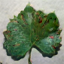

Logits of original image: tensor([[-9.2022,  8.5296]], device='cuda:0')
Logits of generated image: tensor([[-8.6430,  7.5578]], device='cuda:0')


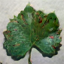

Largest diff: 1.7221951484680176
Largest diff idx: (0, 2435, 0)
Largest diff direction: 0
Logits of image with top-1 attributes flipped: tensor([[-5.8731,  5.2980]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[-5.4463,  4.7899]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[-4.6420,  4.1598]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[-3.9597,  3.5446]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[-3.5187,  3.3639]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[-3.5883,  3.5686]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[-4.2244,  4.1918]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[-3.0317,  3.1381]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[-2.7705,  3.0616]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[-2.8242,  2.8003

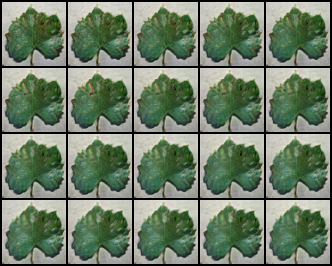

Logits of image with top-[9, 2, 5] attributes flipped: tensor([[-5.3703,  4.6971]], device='cuda:0')
Logits of image with top-[9, 9, 4] attributes flipped: tensor([[-4.8109,  3.9244]], device='cuda:0')
Logits of image with top-[7, 3, 8] attributes flipped: tensor([[-4.7925,  3.8517]], device='cuda:0')
Logits of image with top-[7, 2, 6] attributes flipped: tensor([[-5.7156,  5.2915]], device='cuda:0')
Logits of image with top-[5, 2, 8] attributes flipped: tensor([[-6.5426,  5.7387]], device='cuda:0')
Logits of image with top-[7, 0, 3] attributes flipped: tensor([[-4.4424,  3.9070]], device='cuda:0')
Logits of image with top-[1, 0, 0] attributes flipped: tensor([[-4.8323,  4.1717]], device='cuda:0')
Logits of image with top-[0, 4, 7] attributes flipped: tensor([[-5.6873,  4.8884]], device='cuda:0')
Logits of image with top-[7, 6, 4] attributes flipped: tensor([[-5.0681,  4.2331]], device='cuda:0')
Logits of image with top-[7, 7, 0] attributes flipped: tensor([[-6.4043,  5.7236]], device=

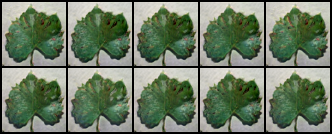

Logits of image with top-1 attributes flipped: tensor([[-11.0484,   9.2800]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[-11.4564,   9.8350]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[-11.5417,   9.7358]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[-11.4805,   9.7673]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[-11.5333,   9.4490]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[-11.9435,   9.7207]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[-12.1036,   9.6263]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[-11.7491,   9.2753]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[-12.5997,  10.5039]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[-12.8674,  10.6088]], device='cuda:0')
Logits of image with top-11 attributes flipped: t

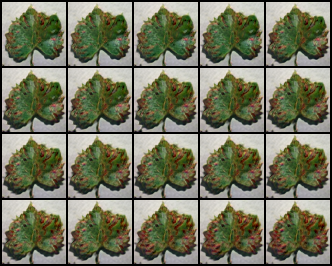

Logits of image with top-[4, 3, 4] attributes flipped: tensor([[-9.9012,  8.1855]], device='cuda:0')
Logits of image with top-[1, 0, 0] attributes flipped: tensor([[-12.0505,   9.8555]], device='cuda:0')
Logits of image with top-[2, 9, 1] attributes flipped: tensor([[-10.3530,   9.2180]], device='cuda:0')
Logits of image with top-[3, 0, 1] attributes flipped: tensor([[-11.6755,   9.9604]], device='cuda:0')
Logits of image with top-[0, 6, 0] attributes flipped: tensor([[-12.6506,  10.6078]], device='cuda:0')
Logits of image with top-[6, 7, 1] attributes flipped: tensor([[-10.7485,   8.9790]], device='cuda:0')
Logits of image with top-[0, 1, 1] attributes flipped: tensor([[-11.0775,   9.6896]], device='cuda:0')
Logits of image with top-[3, 8, 1] attributes flipped: tensor([[-9.8697,  8.7689]], device='cuda:0')
Logits of image with top-[0, 3, 4] attributes flipped: tensor([[-11.7575,   9.6406]], device='cuda:0')
Logits of image with top-[5, 0, 7] attributes flipped: tensor([[-11.1611,   9

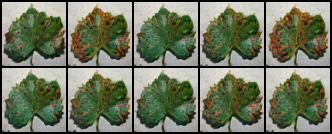

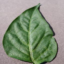

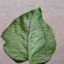

Logits of original image: tensor([[ 3.5750, -4.8874]], device='cuda:0')
Logits of generated image: tensor([[ 1.0791, -1.1194]], device='cuda:0')


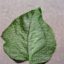

Largest diff: 1.357837438583374
Largest diff idx: (0, 2367, 0)
Largest diff direction: 0
Logits of image with top-1 attributes flipped: tensor([[ 3.1939, -3.1366]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[ 4.0209, -3.6492]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[ 4.2962, -4.3024]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[ 6.6196, -6.4758]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[ 4.4919, -4.4015]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[ 3.5848, -3.3744]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[ 4.2734, -4.2952]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[ 3.9935, -4.0062]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[ 3.5731, -3.6396]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[ 4.0375, -3.8873]

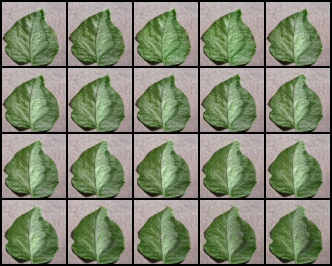

Logits of image with top-[3, 7, 5] attributes flipped: tensor([[ 3.3233, -3.1564]], device='cuda:0')
Logits of image with top-[6, 4, 3] attributes flipped: tensor([[ 2.8677, -3.2604]], device='cuda:0')
Logits of image with top-[6, 6, 0] attributes flipped: tensor([[ 4.4731, -5.0906]], device='cuda:0')
Logits of image with top-[2, 0, 8] attributes flipped: tensor([[ 4.5229, -4.9535]], device='cuda:0')
Logits of image with top-[9, 9, 9] attributes flipped: tensor([[ 3.0866, -3.2790]], device='cuda:0')
Logits of image with top-[2, 1, 0] attributes flipped: tensor([[ 4.2962, -4.3024]], device='cuda:0')
Logits of image with top-[4, 7, 0] attributes flipped: tensor([[ 4.1485, -3.9676]], device='cuda:0')
Logits of image with top-[0, 0, 0] attributes flipped: tensor([[ 1.4664, -0.9493]], device='cuda:0')
Logits of image with top-[2, 7, 8] attributes flipped: tensor([[ 3.8992, -4.3659]], device='cuda:0')
Logits of image with top-[3, 9, 9] attributes flipped: tensor([[ 3.3167, -3.3941]], device=

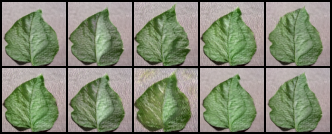

Logits of image with top-1 attributes flipped: tensor([[-0.2205,  0.2384]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[-0.2319,  0.1924]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[-0.3079,  0.1042]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[-1.0606,  0.7933]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[-1.5750,  1.0285]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[-1.6841,  1.0421]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[ 0.7302, -0.4284]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[ 0.8310, -0.7045]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[ 0.8586, -0.8058]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[ 1.0540, -1.0026]], device='cuda:0')
Logits of image with top-11 attributes flipped: tensor([[ 0.8643, -0.

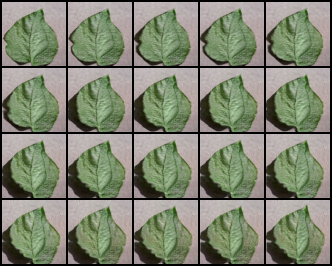

Logits of image with top-[6, 9, 7] attributes flipped: tensor([[-0.6130,  0.5738]], device='cuda:0')
Logits of image with top-[2, 1, 0] attributes flipped: tensor([[-0.3079,  0.1042]], device='cuda:0')
Logits of image with top-[8, 6, 3] attributes flipped: tensor([[-0.9288,  0.9867]], device='cuda:0')
Logits of image with top-[4, 8, 1] attributes flipped: tensor([[-1.2968,  0.9219]], device='cuda:0')
Logits of image with top-[0, 2, 8] attributes flipped: tensor([[-1.4722,  1.2082]], device='cuda:0')
Logits of image with top-[9, 6, 9] attributes flipped: tensor([[-0.5703,  0.3490]], device='cuda:0')
Logits of image with top-[8, 4, 6] attributes flipped: tensor([[-0.8009,  0.7130]], device='cuda:0')
Logits of image with top-[7, 4, 1] attributes flipped: tensor([[ 0.3023, -0.6031]], device='cuda:0')
Logits of image with top-[9, 0, 1] attributes flipped: tensor([[-0.7718,  0.7003]], device='cuda:0')
Logits of image with top-[0, 3, 4] attributes flipped: tensor([[-0.4946,  0.4355]], device=

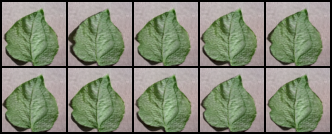

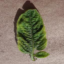

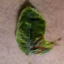

Logits of original image: tensor([[-13.8346,  12.8981]], device='cuda:0')
Logits of generated image: tensor([[-13.2585,  11.8625]], device='cuda:0')


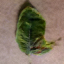

Largest diff: 1.6382360458374023
Largest diff idx: (0, 2451, 0)
Largest diff direction: 0
Logits of image with top-1 attributes flipped: tensor([[-9.8816,  9.3806]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[-8.0370,  6.7727]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[-10.1749,   9.2951]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[-8.7542,  8.2065]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[-7.4554,  6.9445]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[-7.9027,  7.2076]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[-7.7850,  7.3219]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[-5.9615,  4.8410]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[-5.9739,  4.3721]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[-4.5314,  3.10

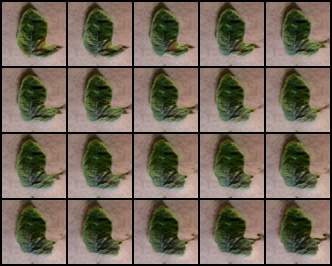

Logits of image with top-[4, 4, 1] attributes flipped: tensor([[-7.2018,  5.7351]], device='cuda:0')
Logits of image with top-[7, 3, 1] attributes flipped: tensor([[-10.0458,   8.4439]], device='cuda:0')
Logits of image with top-[0, 2, 0] attributes flipped: tensor([[-9.3659,  8.8729]], device='cuda:0')
Logits of image with top-[8, 6, 2] attributes flipped: tensor([[-10.8496,   9.6921]], device='cuda:0')
Logits of image with top-[9, 5, 3] attributes flipped: tensor([[-9.2215,  7.9519]], device='cuda:0')
Logits of image with top-[6, 2, 8] attributes flipped: tensor([[-10.8496,   9.6921]], device='cuda:0')
Logits of image with top-[7, 4, 5] attributes flipped: tensor([[-8.8348,  7.3357]], device='cuda:0')
Logits of image with top-[7, 4, 0] attributes flipped: tensor([[-6.6830,  6.1070]], device='cuda:0')
Logits of image with top-[2, 8, 9] attributes flipped: tensor([[-10.8785,   9.4549]], device='cuda:0')
Logits of image with top-[9, 1, 5] attributes flipped: tensor([[-9.3128,  7.4276]],

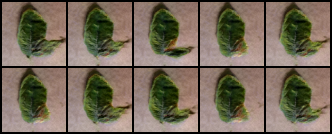

Logits of image with top-1 attributes flipped: tensor([[-15.0577,  13.5008]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[-15.7003,  14.6917]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[-15.4968,  14.7224]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[-15.8359,  14.4278]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[-15.6408,  14.3356]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[-15.5675,  14.4166]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[-16.0071,  14.8740]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[-16.6736,  15.6211]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[-16.7272,  15.5571]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[-16.9928,  15.6893]], device='cuda:0')
Logits of image with top-11 attributes flipped: t

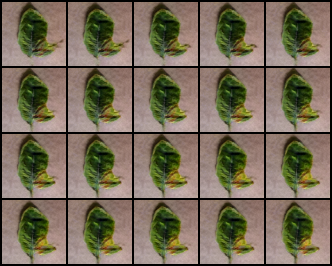

Logits of image with top-[8, 6, 4] attributes flipped: tensor([[-16.1999,  14.8433]], device='cuda:0')
Logits of image with top-[4, 8, 5] attributes flipped: tensor([[-16.9307,  15.0528]], device='cuda:0')
Logits of image with top-[0, 4, 5] attributes flipped: tensor([[-17.4290,  15.7260]], device='cuda:0')
Logits of image with top-[1, 7, 0] attributes flipped: tensor([[-15.9236,  14.9424]], device='cuda:0')
Logits of image with top-[1, 3, 0] attributes flipped: tensor([[-15.7496,  14.5591]], device='cuda:0')
Logits of image with top-[3, 3, 5] attributes flipped: tensor([[-14.9287,  13.2955]], device='cuda:0')
Logits of image with top-[5, 2, 1] attributes flipped: tensor([[-14.4976,  13.7504]], device='cuda:0')
Logits of image with top-[9, 4, 1] attributes flipped: tensor([[-15.2875,  14.4776]], device='cuda:0')
Logits of image with top-[3, 8, 5] attributes flipped: tensor([[-15.9452,  14.4509]], device='cuda:0')
Logits of image with top-[7, 8, 3] attributes flipped: tensor([[-15.5744,

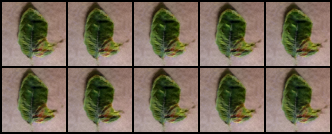

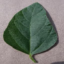

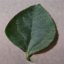

Logits of original image: tensor([[ 5.3418, -5.7284]], device='cuda:0')
Logits of generated image: tensor([[ 1.4868, -1.6015]], device='cuda:0')


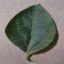

Largest diff: 3.084709405899048
Largest diff idx: (0, 2460, 1)
Largest diff direction: 1
Logits of image with top-1 attributes flipped: tensor([[ 4.8271, -4.6037]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[ 6.2370, -5.7667]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[ 6.7184, -5.6400]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[ 6.7179, -5.7487]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[ 5.9557, -5.2917]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[ 5.0791, -4.3630]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[ 4.2286, -3.5455]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[ 3.5970, -2.9492]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[ 3.5251, -2.9196]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[ 3.5791, -3.2421]

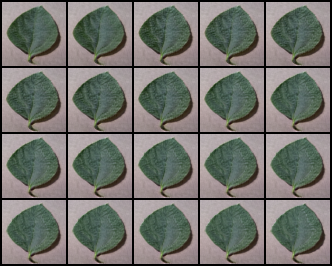

Logits of image with top-[4, 2, 9] attributes flipped: tensor([[ 3.8591, -3.1674]], device='cuda:0')
Logits of image with top-[4, 5, 5] attributes flipped: tensor([[ 4.3530, -4.3660]], device='cuda:0')
Logits of image with top-[9, 8, 0] attributes flipped: tensor([[ 4.9455, -4.5125]], device='cuda:0')
Logits of image with top-[6, 8, 8] attributes flipped: tensor([[ 2.8090, -2.7845]], device='cuda:0')
Logits of image with top-[0, 7, 3] attributes flipped: tensor([[ 5.6739, -5.2377]], device='cuda:0')
Logits of image with top-[4, 8, 6] attributes flipped: tensor([[ 3.8971, -4.0754]], device='cuda:0')
Logits of image with top-[4, 2, 6] attributes flipped: tensor([[ 3.6853, -3.1004]], device='cuda:0')
Logits of image with top-[3, 2, 4] attributes flipped: tensor([[ 4.6903, -4.2189]], device='cuda:0')
Logits of image with top-[0, 7, 7] attributes flipped: tensor([[ 4.8972, -4.6101]], device='cuda:0')
Logits of image with top-[6, 4, 4] attributes flipped: tensor([[ 2.8266, -2.9721]], device=

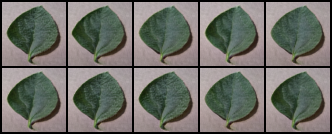

Logits of image with top-1 attributes flipped: tensor([[-2.0204,  1.4832]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[-3.3837,  2.7670]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[-3.1621,  2.5654]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[-3.3142,  2.2193]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[-2.7180,  1.7509]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[-5.0813,  4.2396]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[-6.6387,  5.6988]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[-6.2121,  5.3188]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[-7.3225,  6.5317]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[-7.1657,  6.3384]], device='cuda:0')
Logits of image with top-11 attributes flipped: tensor([[-7.4786,  6.

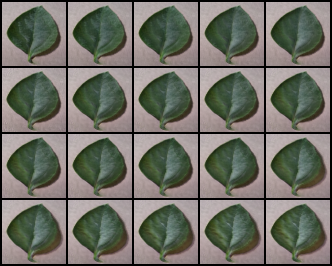

Logits of image with top-[4, 0, 6] attributes flipped: tensor([[-4.0321,  3.5651]], device='cuda:0')
Logits of image with top-[4, 2, 6] attributes flipped: tensor([[-3.2506,  2.8281]], device='cuda:0')
Logits of image with top-[5, 2, 6] attributes flipped: tensor([[-4.4916,  3.7066]], device='cuda:0')
Logits of image with top-[7, 4, 3] attributes flipped: tensor([[-3.0773,  2.5561]], device='cuda:0')
Logits of image with top-[8, 0, 7] attributes flipped: tensor([[-4.8148,  3.7999]], device='cuda:0')
Logits of image with top-[3, 6, 2] attributes flipped: tensor([[-2.0324,  1.4906]], device='cuda:0')
Logits of image with top-[4, 1, 3] attributes flipped: tensor([[-1.4038,  0.7553]], device='cuda:0')
Logits of image with top-[8, 1, 3] attributes flipped: tensor([[-1.7273,  0.7499]], device='cuda:0')
Logits of image with top-[9, 4, 7] attributes flipped: tensor([[-3.2059,  2.7157]], device='cuda:0')
Logits of image with top-[8, 6, 7] attributes flipped: tensor([[-3.2132,  2.6869]], device=

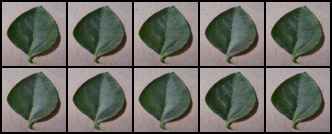

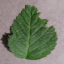

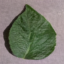

Logits of original image: tensor([[ 4.7188, -4.3238]], device='cuda:0')
Logits of generated image: tensor([[ 2.7831, -3.5605]], device='cuda:0')


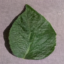

Largest diff: 2.511812686920166
Largest diff idx: (0, 2434, 0)
Largest diff direction: 0
Logits of image with top-1 attributes flipped: tensor([[ 4.8285, -5.0198]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[ 6.6984, -7.1210]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[ 6.5686, -6.7195]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[ 6.6197, -6.8644]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[ 6.9545, -7.4918]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[ 7.1318, -7.7547]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[ 7.2942, -7.6218]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[ 7.6896, -7.9624]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[ 7.1935, -7.5269]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[ 7.6807, -7.6962]

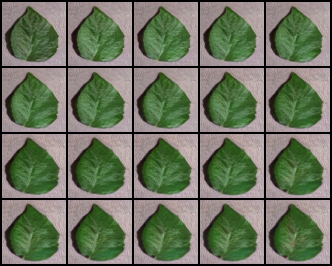

Logits of image with top-[3, 4, 6] attributes flipped: tensor([[ 5.4471, -5.9384]], device='cuda:0')
Logits of image with top-[8, 4, 7] attributes flipped: tensor([[ 4.9558, -4.9931]], device='cuda:0')
Logits of image with top-[3, 0, 7] attributes flipped: tensor([[ 5.8091, -6.0383]], device='cuda:0')
Logits of image with top-[8, 3, 9] attributes flipped: tensor([[ 5.2712, -5.2484]], device='cuda:0')
Logits of image with top-[3, 7, 6] attributes flipped: tensor([[ 5.3630, -5.8577]], device='cuda:0')
Logits of image with top-[2, 9, 9] attributes flipped: tensor([[ 1.2447, -1.3768]], device='cuda:0')
Logits of image with top-[0, 8, 8] attributes flipped: tensor([[ 4.6872, -4.4080]], device='cuda:0')
Logits of image with top-[6, 4, 6] attributes flipped: tensor([[ 3.3289, -3.5814]], device='cuda:0')
Logits of image with top-[9, 5, 1] attributes flipped: tensor([[ 5.7797, -6.7435]], device='cuda:0')
Logits of image with top-[8, 2, 2] attributes flipped: tensor([[ 3.5442, -3.6010]], device=

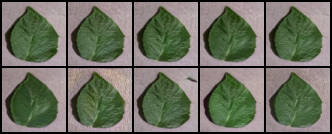

Logits of image with top-1 attributes flipped: tensor([[ 0.5199, -1.0487]], device='cuda:0')
Logits of image with top-2 attributes flipped: tensor([[-1.0020,  1.0237]], device='cuda:0')
Logits of image with top-3 attributes flipped: tensor([[ 1.0552, -0.9894]], device='cuda:0')
Logits of image with top-4 attributes flipped: tensor([[0.1081, 0.2064]], device='cuda:0')
Logits of image with top-5 attributes flipped: tensor([[0.1523, 0.0269]], device='cuda:0')
Logits of image with top-6 attributes flipped: tensor([[ 1.5463, -1.2263]], device='cuda:0')
Logits of image with top-7 attributes flipped: tensor([[ 1.1926, -0.4230]], device='cuda:0')
Logits of image with top-8 attributes flipped: tensor([[-1.4759,  1.8394]], device='cuda:0')
Logits of image with top-9 attributes flipped: tensor([[-2.8380,  2.9644]], device='cuda:0')
Logits of image with top-10 attributes flipped: tensor([[-2.9756,  2.9269]], device='cuda:0')
Logits of image with top-11 attributes flipped: tensor([[-2.4304,  2.4813

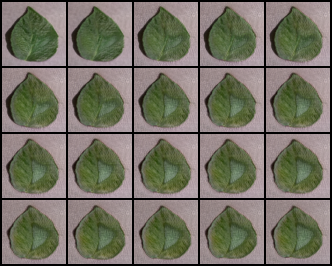

Logits of image with top-[8, 6, 1] attributes flipped: tensor([[-0.4314,  0.6190]], device='cuda:0')
Logits of image with top-[5, 3, 2] attributes flipped: tensor([[ 0.7894, -0.6437]], device='cuda:0')
Logits of image with top-[4, 2, 6] attributes flipped: tensor([[ 2.6467, -2.2557]], device='cuda:0')
Logits of image with top-[1, 5, 0] attributes flipped: tensor([[-1.2168,  1.0788]], device='cuda:0')
Logits of image with top-[9, 6, 9] attributes flipped: tensor([[ 0.5370, -0.9464]], device='cuda:0')
Logits of image with top-[1, 9, 2] attributes flipped: tensor([[ 3.6872, -3.2415]], device='cuda:0')
Logits of image with top-[4, 0, 5] attributes flipped: tensor([[-0.8561,  0.8758]], device='cuda:0')
Logits of image with top-[9, 0, 3] attributes flipped: tensor([[ 0.4323, -1.1256]], device='cuda:0')
Logits of image with top-[4, 4, 4] attributes flipped: tensor([[ 0.2901, -0.9143]], device='cuda:0')
Logits of image with top-[3, 1, 7] attributes flipped: tensor([[-0.8883,  0.6905]], device=

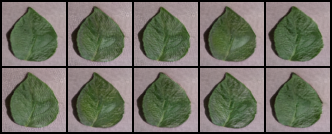

IndexError: index 16 is out of bounds for dimension 0 with size 16

In [27]:
run_attrfind()